In [1]:
# Importing The required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# importing the data_set
data = pd.read_csv('../../data/processed/fully_integrated_data.csv')
data.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

### Feature Selection

In [3]:
# Calculate performance metrics
data['position_change'] = data['driverStartGridPos'] - data['driverFinalRank']
data['percent_improvement'] = (data['position_change'] / data['driverStartGridPos']) * 100
data['overtakes'] = data.apply(lambda x: max(0, x['driverStartGridPos'] - x['driverFinalRank']), axis=1)
data['defended_position'] = data.apply(lambda x: 1 if x['driverStartGridPos'] >= x['driverFinalRank'] else 0, axis=1)

# Create comprehensive driver analysis
driver_performance = data.groupby('driverName').agg({
    'driverStartGridPos': ['mean', 'std'],      # Qualifying performance
    'driverFinalRank': ['mean', 'std'],         # Race performance
    'position_change': ['mean', 'std'],         # Position change consistency
    'percent_improvement': ['mean', 'std'],     # Improvement rate
    'overtakes': 'sum',                         # Total overtakes
    'defended_position': 'mean',                # Position defense rate
    'raceId': 'count'                          # Number of races
}).round(2)

# Flatten column names
driver_performance.columns = ['_'.join(col).strip() for col in driver_performance.columns]


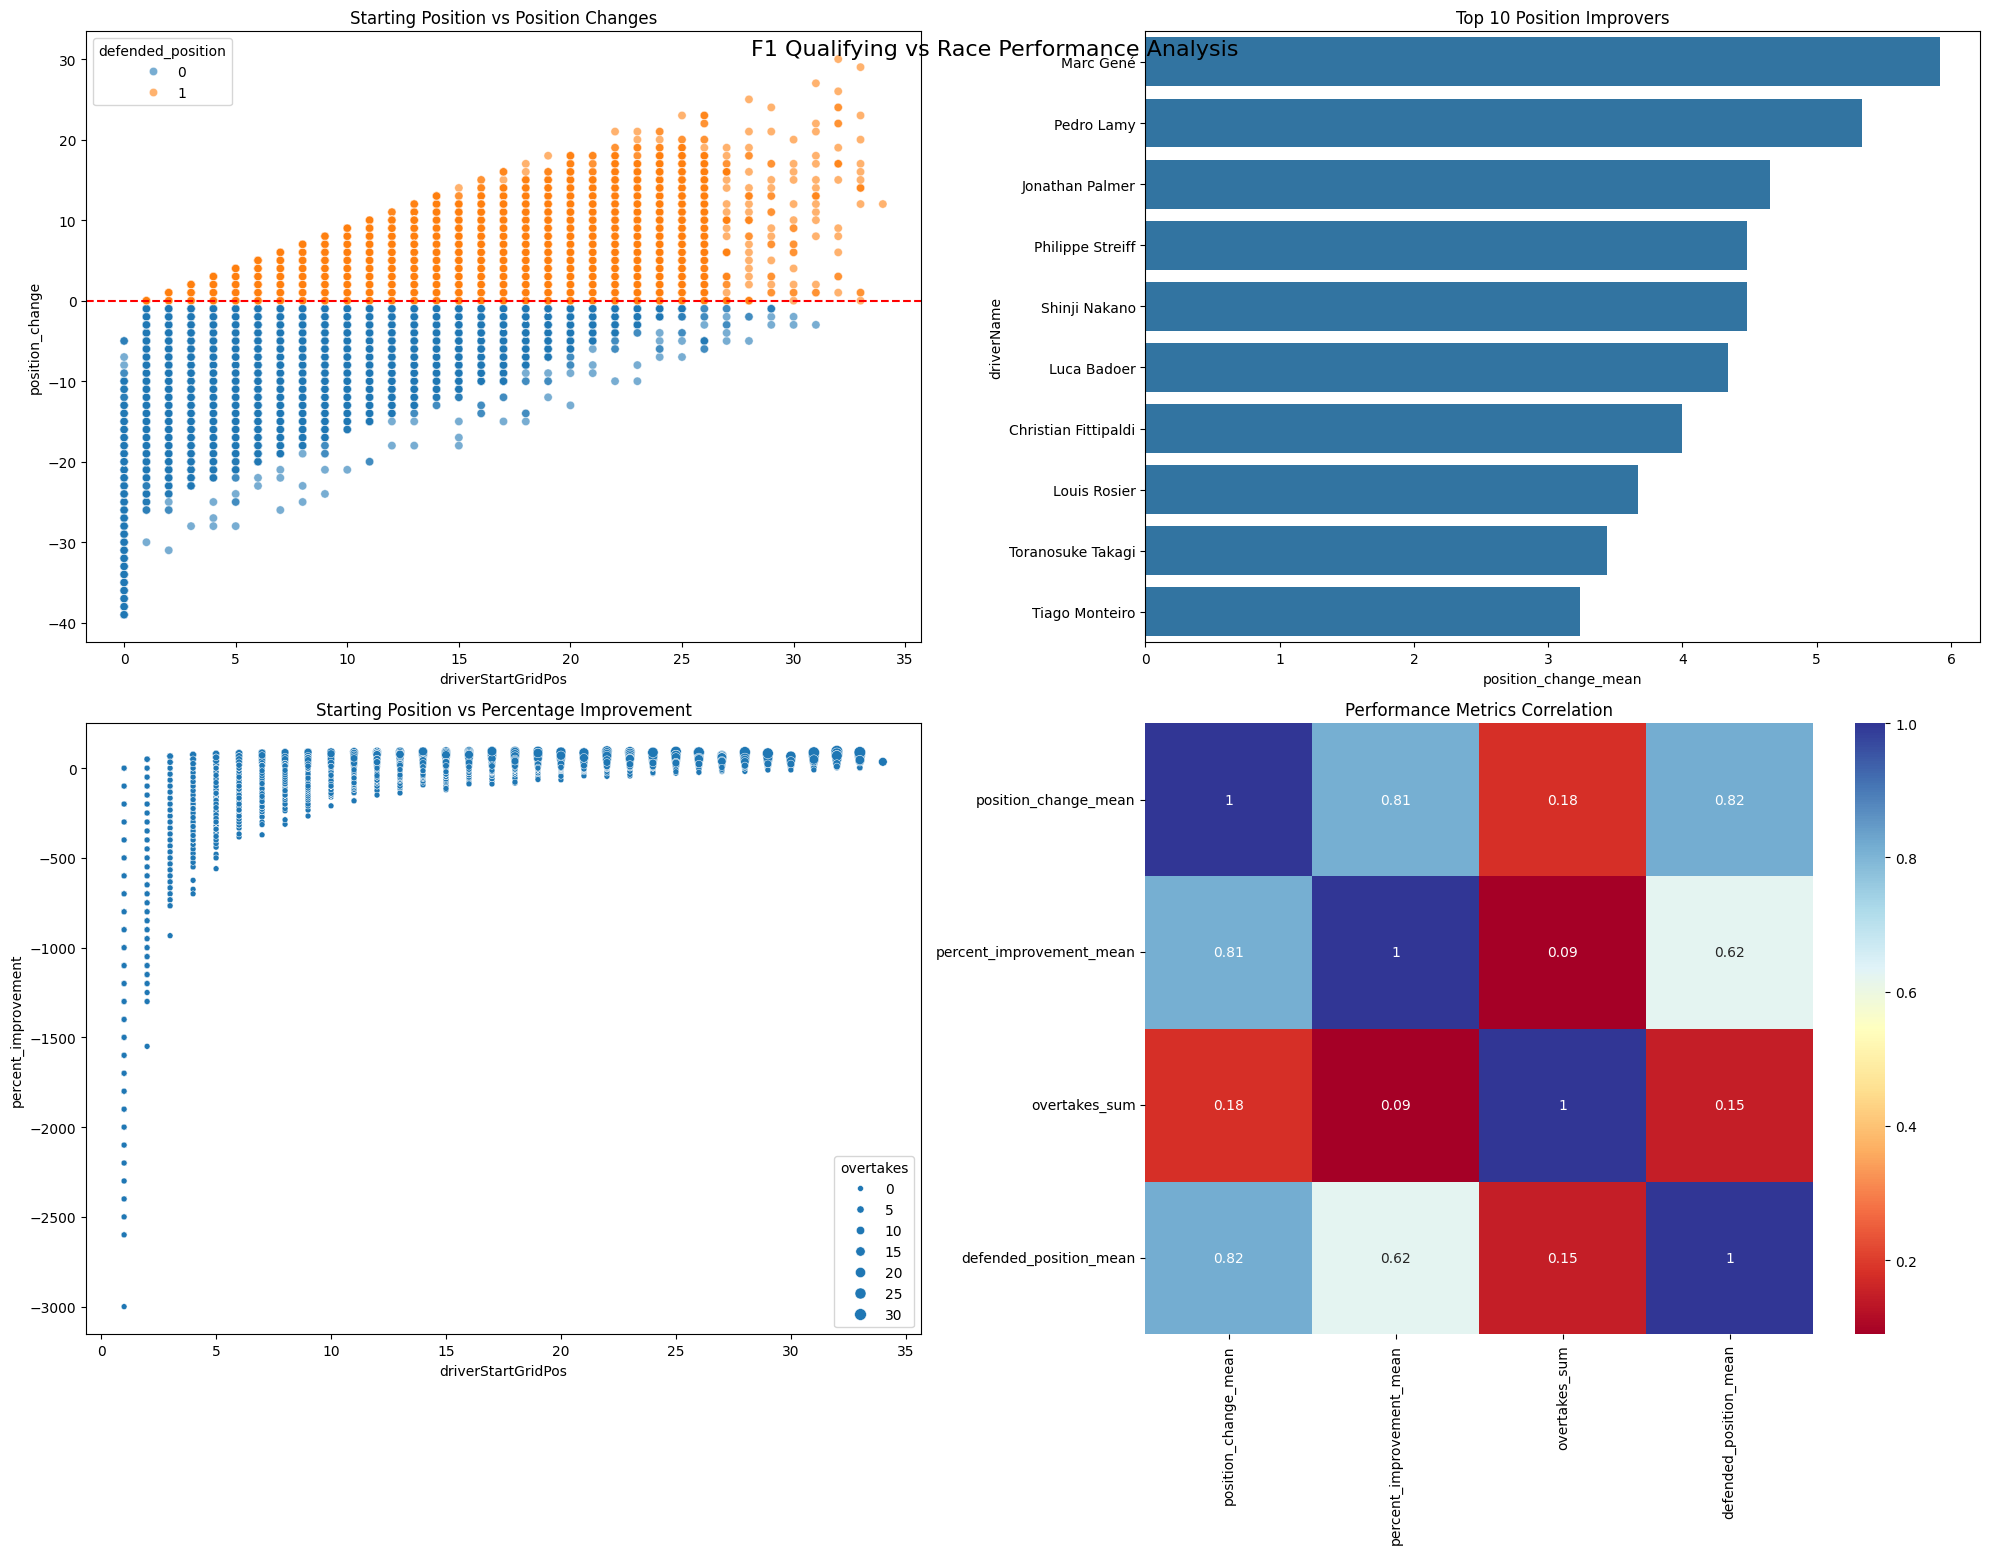


Qualifying vs Race Performance Analysis:

1. Top 5 Position Improvers:
                  position_change_mean  percent_improvement_mean  \
driverName                                                         
Marc Gené                         5.92                     28.41   
Pedro Lamy                        5.34                     27.87   
Jonathan Palmer                   4.65                      -inf   
Philippe Streiff                  4.48                     18.66   
Shinji Nakano                     4.48                     22.73   

                  overtakes_sum  
driverName                       
Marc Gené                   218  
Pedro Lamy                  185  
Jonathan Palmer             585  
Philippe Streiff            332  
Shinji Nakano               174  

2. Most Consistent Qualifiers vs Race Performance:
                driverStartGridPos_mean  driverStartGridPos_std  \
driverName                                                        
Max Chilton                

In [4]:
# Filter for drivers with minimum 30 races
driver_performance = driver_performance[driver_performance['raceId_count'] >= 30]

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
plt.suptitle('F1 Qualifying vs Race Performance Analysis', fontsize=16, y=0.95)

# 1. Position Changes Distribution
sns.scatterplot(data=data, 
                x='driverStartGridPos', 
                y='position_change',
                hue='defended_position',
                alpha=0.6,
                ax=axes[0,0])
axes[0,0].set_title('Starting Position vs Position Changes')
axes[0,0].axhline(y=0, color='r', linestyle='--')

# 2. Top Position Improvers
top_improvers = driver_performance.nlargest(10, 'position_change_mean')
sns.barplot(data=top_improvers,
            y=top_improvers.index,
            x='position_change_mean',
            ax=axes[0,1])
axes[0,1].set_title('Top 10 Position Improvers')

# 3. Percentage Improvement vs Starting Position
sns.scatterplot(data=data,
                x='driverStartGridPos',
                y='percent_improvement',
                size='overtakes',
                ax=axes[1,0])
axes[1,0].set_title('Starting Position vs Percentage Improvement')

# 4. Performance Correlation Matrix
performance_matrix = driver_performance[[
    'position_change_mean',
    'percent_improvement_mean',
    'overtakes_sum',
    'defended_position_mean'
]].corr()
sns.heatmap(performance_matrix,
            annot=True,
            cmap='RdYlBu',
            ax=axes[1,1])
axes[1,1].set_title('Performance Metrics Correlation')

plt.tight_layout()
plt.show()

# Print statistical insights
print("\nQualifying vs Race Performance Analysis:")
print("\n1. Top 5 Position Improvers:")
print(driver_performance.nlargest(5, 'position_change_mean')[[
    'position_change_mean', 
    'percent_improvement_mean',
    'overtakes_sum'
]])

print("\n2. Most Consistent Qualifiers vs Race Performance:")
consistency_matrix = driver_performance.nsmallest(5, 'driverStartGridPos_std')[[
    'driverStartGridPos_mean',
    'driverStartGridPos_std',
    'position_change_mean'
]]
print(consistency_matrix)

print("\n3. Starting Position Impact:")
pos_change_corr = data['driverStartGridPos'].corr(data['position_change'])
print(f"Correlation between starting position and position change: {pos_change_corr:.3f}")

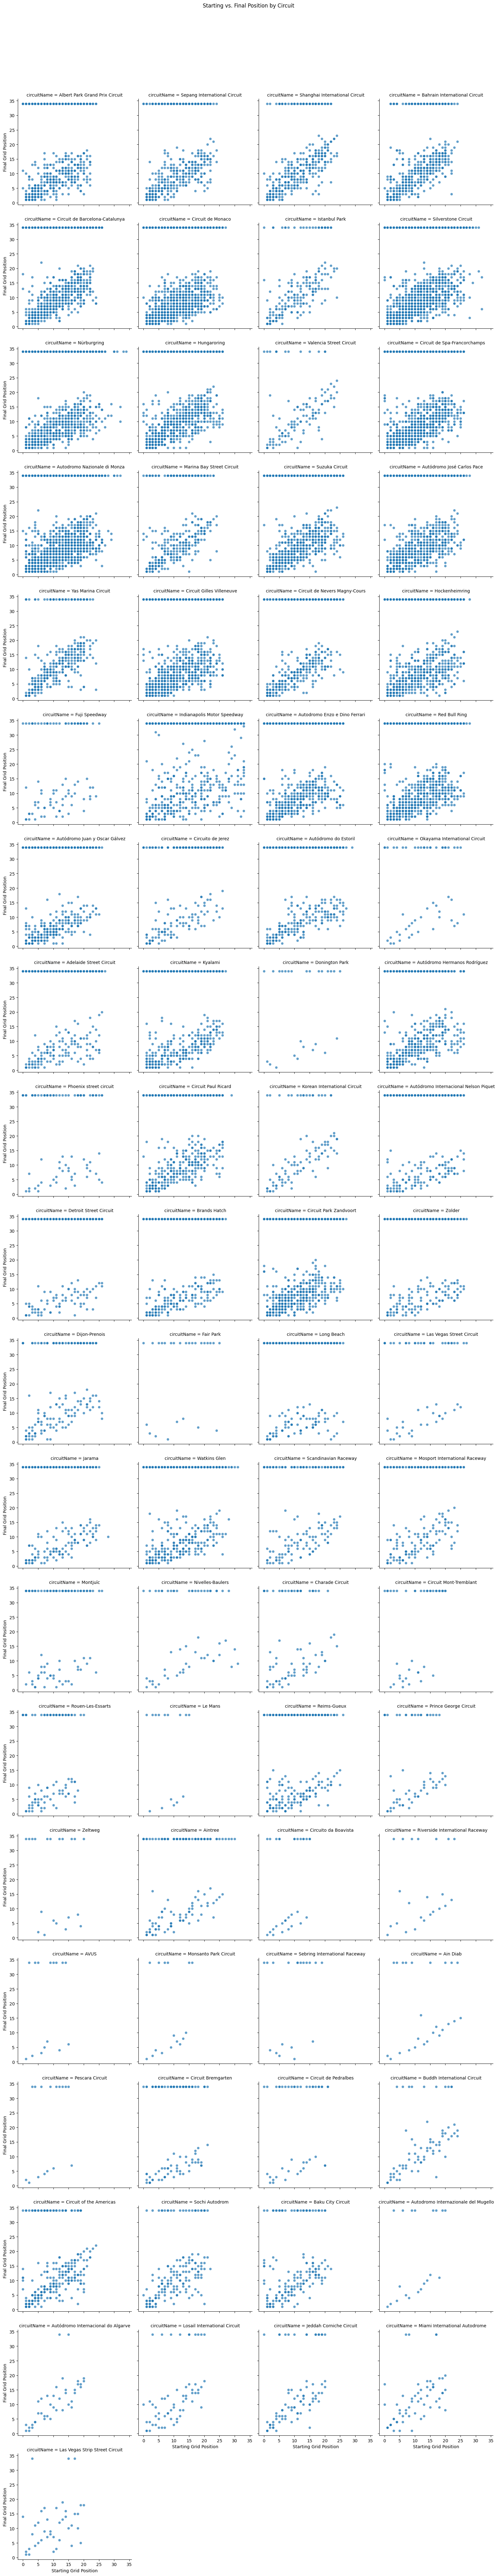

In [5]:
avg_position_change = data.groupby('driverId')['position_change'].mean().reset_index()
avg_position_change.columns = ['driverId', 'avgPositionGain']
grid_positions = data['driverStartGridPos'].unique()
grouped_final_positions = [data[data['driverStartGridPos'] == pos]['driverFinalGridPos'] for pos in grid_positions]

g = sns.FacetGrid(
    data=data,
    col="circuitName",     # Create a separate subplot for each circuit
    col_wrap=4,            # How many plots per row
    height=4,              # Height of each subplot
    aspect=1
)

g.map_dataframe(
    sns.scatterplot,
    x="driverStartGridPos",
    y="driverFinalGridPos",
    alpha=0.7
)

g.set_axis_labels("Starting Grid Position", "Final Grid Position")
g.fig.suptitle("Starting vs. Final Position by Circuit", y=1.03)
plt.tight_layout()
plt.show()

In [9]:

import statsmodels.api as sm
from statsmodels.formula.api import ols


# driverFinalGridPos ~ driverStartGridPos + circuitId
model_ancova = ols("driverFinalGridPos ~ driverStartGridPos + C(circuitId)", data=data).fit()
ancova_table = sm.stats.anova_lm(model_ancova, typ=2)

data['ancova_resid'] = model_ancova.resid  #  storing The model_ancova  for further Statiscal analysis
ancova_table


,sum_sq,df,F,PR(>F)
C(circuitId),1.622117e+05,76.0,12.756820,8.241974e-152
driverStartGridPos,1.092338e+05,1.0,652.876558,2.725949e-142
Residual,4.464041e+06,26681.0,NaN,NaN


Let's break down the ANCOVA results:

The model is  modeling the final grid position as a function of the starting grid position (a covariate) and the circuit (a categorical factor).

### **Key Results**

1. **driverStartGridPos**  
   - **Sum of Squares:** 1.092338e+05  
   - **df:** 1  
   - **F-value:** 652.88  
   - **p-value:** 2.73e-142  
   
   **Interpretation:**  
   The extremely high F-value and a p-value near zero indicate that the starting grid position is a very strong predictor of the final grid position. In other words, where a driver starts has a huge influence on where they finish.

2. **C(circuitId)**  
   - **Sum of Squares:** 1.622117e+05  
   - **df:** 76  
   - **F-value:** 12.76  
   - **p-value:** 8.24e-152  
   
   **Interpretation:**  
   Even after controlling for starting grid position, the circuit has a statistically significant effect on the final grid position (p-value is essentially zero). This means that the track or circuit characteristics play an important role in determining how much a driver can improve or lose positions during a race. The F-value of 12.76, while lower than that for the starting position, is still high enough to indicate a strong effect.

3. **Residual**  
   - **Sum of Squares:** 4.464041e+06  
   - **df:** 26681  
   
   **Interpretation:**  
   The residual sum of squares represents the variance in final grid position not explained by the model. With 26681 degrees of freedom, this value gives you an idea of the overall error. In ANCOVA, a lower residual sum of squares (relative to the sum of squares explained by the factors) indicates a better fitting model.

### **Overall Conclusions**

- **Starting Grid Position:**  
  Has a dominant influence on the final position, which is expected in races where starting well often leads to a better finish.

- **Circuit Influence:**  
  The highly significant p-value for circuit (p < 0.0001) shows that the circuit (or track characteristics) matters. Different circuits can either help or hinder a driver's ability to overtake, meaning the track layout or conditions affect the final positions beyond what the starting grid position would predict.

- **Practical Implication:**  
  When planning strategies or analyzing race outcomes, it's not enough to consider just the starting positions; the circuit itself plays a critical role. This insight is valuable for both race strategy and predictive modeling, especially if you plan to simulate driver swaps or adjust for track-specific dynamics.

In summary, the ANCOVA results demonstrate that both the starting grid position and the circuit have significant and independent effects on the final grid positions.

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=data['ancova_resid'],   # The residual from ANCOVA
    groups=data['circuitName'],       # Circuit as the group/factor
    alpha=0.05
)

print(tukey)


                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                                
                group1                                group2                meandiff p-adj  lower    upper  reject
------------------------------------------------------------------------------------------------------------------
                                 AVUS               Adelaide Street Circuit      0.0   1.0 -14.3211 14.3211  False
                                 AVUS                              Ain Diab     -0.0   1.0 -17.6945 17.6945  False
                                 AVUS                               Aintree     -0.0   1.0 -14.7294 14.7294  False
                                 AVUS        Albert Park Grand Prix Circuit     -0.0   1.0 -14.1694 14.1694  False
                                 AVUS         Autodromo Enzo e Dino Ferrari     -0.0   1.0 -14.1235 14.1235  False
                                 AVUS  Autodromo Internazionale del Mugello     

The pairwise Tukey HSD test, however, reveals that none of the individual circuit pairs differ significantly from each other. The confidence intervals for the differences (e.g., from about -14 to +14) all include zero, and the adjusted p-values are 1.0, so we fail to reject the null hypothesis for any pair.

### Interpretation:
- **Group Effect vs. Individual Differences:**  
  While the circuit factor as a whole is significant, the effect is distributed across many circuits in such a way that no single pair of circuits shows a statistically significant difference in their influence on the final grid position (after adjusting for the starting position).
  
- **Practical Implication:**  
  This might mean that although track characteristics (circuit) do affect how much drivers gain or lose positions overall, the differences between any two specific circuits are not strong enough to be detected by Tukey’s test. In other words, there is significant variability among circuits collectively, but the pairwise differences are relatively small compared to the overall variability.


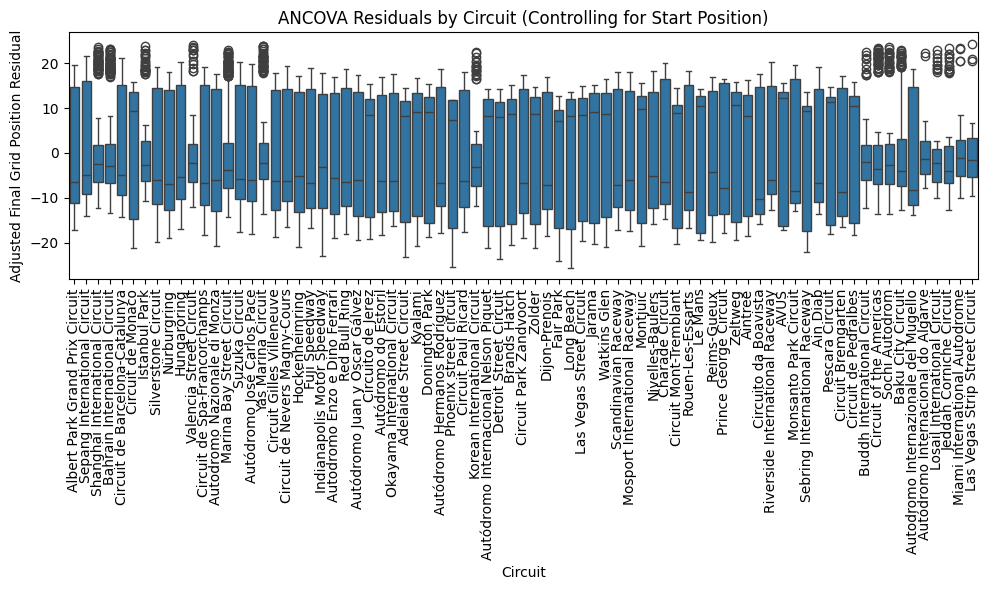

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='circuitId', y='ancova_resid', data=data)
plt.title("ANCOVA Residuals by Circuit (Controlling for Start Position)")
plt.xlabel("Circuit")
plt.ylabel("Adjusted Final Grid Position Residual")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
